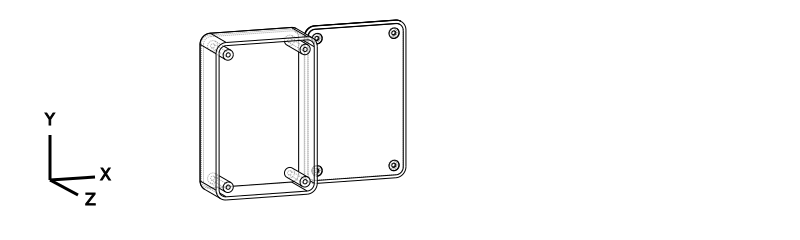

In [9]:
import cadquery as cq
from cadquery import exporters
from IPython.display import SVG, DisplayObject

# parameter definitions
p_outerWidth = 100.0  # Outer width of box enclosure
p_outerLength = 150.0  # Outer length of box enclosure
p_outerHeight = 50.0  # Outer height of box enclosure

p_thickness = 3.0  # Thickness of the box walls
p_sideRadius = 10.0  # Radius for the curves around the sides of the box
p_topAndBottomRadius = (
    2.0  # Radius for the curves on the top and bottom edges of the box
)

p_screwpostInset = 12.0  # How far in from the edges the screw posts should be place.
p_screwpostID = 4.0  # Inner Diameter of the screw post holes, should be roughly screw diameter not including threads
p_screwpostOD = 10.0  # Outer Diameter of the screw posts.\nDetermines overall thickness of the posts

p_boreDiameter = 8.0  # Diameter of the counterbore hole, if any
p_boreDepth = 1.0  # Depth of the counterbore hole, if
p_countersinkDiameter = 0.0  # Outer diameter of countersink. Should roughly match the outer diameter of the screw head
p_countersinkAngle = 90.0  # Countersink angle (complete angle between opposite sides, not from center to one side)
p_flipLid = True  # Whether to place the lid with the top facing down or not.
p_lipHeight = 1.0  # Height of lip on the underside of the lid.\nSits inside the box body for a snug fit.

# outer shell
oshell = (
    cq.Workplane("XY")
    .rect(p_outerWidth, p_outerLength)
    .extrude(p_outerHeight + p_lipHeight)
)

# weird geometry happens if we make the fillets in the wrong order
if p_sideRadius > p_topAndBottomRadius:
    oshell = oshell.edges("|Z").fillet(p_sideRadius)
    oshell = oshell.edges("#Z").fillet(p_topAndBottomRadius)
else:
    oshell = oshell.edges("#Z").fillet(p_topAndBottomRadius)
    oshell = oshell.edges("|Z").fillet(p_sideRadius)

# inner shell
ishell = (
    oshell.faces("<Z")
    .workplane(p_thickness, True)
    .rect((p_outerWidth - 2.0 * p_thickness), (p_outerLength - 2.0 * p_thickness))
    .extrude(
        (p_outerHeight - 2.0 * p_thickness), False
    )  # set combine false to produce just the new boss
)
ishell = ishell.edges("|Z").fillet(p_sideRadius - p_thickness)

# make the box outer box
box = oshell.cut(ishell)

# make the screw posts
POSTWIDTH = p_outerWidth - 2.0 * p_screwpostInset
POSTLENGTH = p_outerLength - 2.0 * p_screwpostInset

box = (
    box.faces(">Z")
    .workplane(-p_thickness)
    .rect(POSTWIDTH, POSTLENGTH, forConstruction=True)
    .vertices()
    .circle(p_screwpostOD / 2.0)
    .circle(p_screwpostID / 2.0)
    .extrude(-1.0 * (p_outerHeight + p_lipHeight - p_thickness), True)
)

# split lid into top and bottom parts
(lid, bottom) = (
    box.faces(">Z")
    .workplane(-p_thickness - p_lipHeight)
    .split(keepTop=True, keepBottom=True)
    .all()
)  # splits into two solids

# translate the lid, and subtract the bottom from it to produce the lid inset
lowerLid = lid.translate((0, 0, -p_lipHeight))
cutlip = lowerLid.cut(bottom).translate(
    (p_outerWidth + p_thickness, 0, p_thickness - p_outerHeight + p_lipHeight)
)

# compute centers for screw holes
topOfLidCenters = (
    cutlip.faces(">Z")
    .workplane(centerOption="CenterOfMass")
    .rect(POSTWIDTH, POSTLENGTH, forConstruction=True)
    .vertices()
)

# add holes of the desired type
if p_boreDiameter > 0 and p_boreDepth > 0:
    topOfLid = topOfLidCenters.cboreHole(
        p_screwpostID, p_boreDiameter, p_boreDepth, 2.0 * p_thickness
    )
elif p_countersinkDiameter > 0 and p_countersinkAngle > 0:
    topOfLid = topOfLidCenters.cskHole(
        p_screwpostID, p_countersinkDiameter, p_countersinkAngle, 2.0 * p_thickness
    )
else:
    topOfLid = topOfLidCenters.hole(p_screwpostID, 2.0 * p_thickness)

# flip lid upside down if desired
if p_flipLid:
    topOfLid = topOfLid.rotateAboutCenter((1, 0, 0), 180)

# return the combined result
result = topOfLid.union(bottom)

exporters.export(result, 'tmp.stl')

display(SVG(result.toSvg()))
